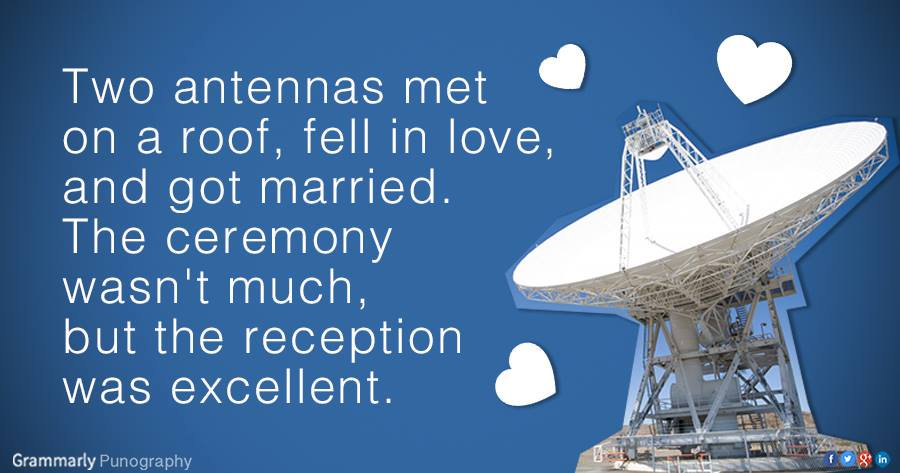

In [1]:
from IPython.display import Image
Image('https://pbs.twimg.com/media/B9HzS_8CUAEWVhq.jpg')

In [3]:
       
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlb
import ugradio.pico as pco
import ugradio.dft as dft
import ugradio.interf as ifm
import ugradio.hp_multi as hpm
import ugradio.coord as crd
from time import sleep
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz, get_body
from astropy.time import Time
ifm = ifm.Interferometer()
hpm = hpm.HP_Multimeter()

'''
crab = SkyCoord(l = 184.5575*u.degree, b = -5.7844*u.degree, equinox frame = 'galactic')
crab = crab.fk5
print(crab.ra.deg, crab.dec.deg)
'''

# hpm.start_recording(1)
# for t in range(30600):
# 	sleep(1)
# 	data,time = hpm.get_recording_data()
# 	print(t,round(data[-1],6),time[-1])

# 	if(t%120 == 0):
# 		cAlt,cAz = crd.get_altaz(  8, 22.014436212370363)

# 		print(ifm.get_pointing())
# 		print(cAlt,cAz)
# 		ifm.point(cAlt,cAz)
# 		print(ifm.get_pointing())
	
# 	if(t%600 == 0):
# 		np.savez('CrabData' + str(t/300),time,data)
		
# hpm.end_recording()		


# hpm.start_recording(1)
# for t in range(3600):
# 	sleep(1)
# 	data,time = hpm.get_recording_data()
# 	print(t,round(data[-1],6),time[-1])

# 	if(t%120 == 0):
#  		sRA,sDec = crd.sunpos()
# 		mRA,mDec = crd.moonpos()
# 		sAlt,sAz = crd.get_altaz(sRA,sDec)
# 		mAlt,mAz = crd.get_altaz(mRA,mDec)

# 		print(ifm.get_pointing())
# 		print(mAlt,mAz)
# 		ifm.point(mAlt,mAz)
# 		print(ifm.get_pointing())
# 		np.savez('MoonData2',time,data)
		
# hpm.end_recording()		


# hpm.start_recording(1)
# for t in range(1800):
# 	sleep(1)
# 	data,time = hpm.get_recording_data()
# 	print(t,round(data[-1],6),time[-1])

# 	if(t%120 == 0): 
		
# 		jAlt,jAz = crd.get_altaz(230.7875, -17.351916)

# 		print(ifm.get_pointing())
# 		print(cAlt,cAz)
# 		ifm.point(jAlt,jAz)
# 		print(ifm.get_pointing())
# 		np.savez('JupiterData',time,data)
		
# hpm.end_recording()		


# print(time,data)




"\ncrab = SkyCoord(l = 184.5575*u.degree, b = -5.7844*u.degree, equinox frame = 'galactic')\ncrab = crab.fk5\nprint(crab.ra.deg, crab.dec.deg)\n"

In [4]:
import numpy as np 
import ugradio
import matplotlib.pylab as pl
%matplotlib inline

data = r"/home/data/all_data_3_12/"
crab = np.load(data + "CrabDataR40.npz")
crabV = crab["arr_1"]
crabT = ( crab["arr_0"][len(crab["arr_0"])-1] - crab["arr_0"][0] ) / len(crab["arr_0"])
moon = np.load(data + "MoonData37.npz")
moonV = moon["arr_1"]
print(len(moonV))
moonT = ( moon["arr_0"][len(moon["arr_0"])-1] - moon["arr_0"][0] ) / len(moon["arr_0"])
sun = np.load(data + "SunDataR52.npz")
sunV = sun["arr_1"]
sunT = (sun["arr_0"][len(sun["arr_0"])-1] - sun["arr_0"][0]) / len(sun["arr_0"])
print ugradio.timing.lst(ugradio.timing.julian_date(crab["arr_0"][0]))

def plotPower(arr, spacing, log=False):
    arr = np.subtract(arr, np.mean(arr))
    voltage = np.fft.fft(arr)
    freqs = np.fft.fftfreq(len(voltage), spacing)
    power = np.abs(voltage)**2
    
    freqsG = np.fft.fftshift(freqs)[len(power)/2 + 5:]
    powerG = np.fft.fftshift(power)[len(power)/2 + 5:]
    
    freqsH = np.fft.fftshift(freqs)
    powerH = np.fft.fftshift(power)
    
    if log:
        pl.semilogy(freqsG, powerG, 'k')
    else:
        pl.plot(freqsG, powerG, 'k')
    
    #print [np.argmax(powerG)]
    return freqsG[np.argmax(powerG)]

23998
0.640914951497


In [5]:
def ideal_fringe_freq(data, dec, spacing):
    f_f_ideal = []
    LST = []
    for i in range(len(data["arr_0"])/spacing):
        currentLST = ugradio.timing.lst(ugradio.timing.julian_date(data["arr_0"][i*spacing]))
        LST.append(currentLST)
        ra = 1.46
        h = currentLST - ra
        f_f_ideal.append(0.037*np.cos(dec)*np.cos(h))
    return LST, f_f_ideal

def actual_fringe_freq(arr, spacing):
    #arr = np.subtract(arr, np.mean(arr))
    arrT = ( arr["arr_0"][len(arr["arr_0"])-1] - arr["arr_0"][0] ) / len(arr["arr_0"])
    f_f_actual = []
    for i in range(len(arr["arr_0"])/spacing):
        
        #Implementing the window functions
        windowed = np.multiply(arr["arr_1"][i*spacing:(i+1)*spacing], np.hamming(spacing))
        
        
        voltage = np.fft.fft(windowed)
        freqs = np.fft.fftfreq(len(voltage), arrT)
        power = np.abs(voltage)**2
        freqsH = np.fft.fftshift(freqs)
        powerH = np.fft.fftshift(power)
        powerH[len(powerH)/2-spacing/500:len(powerH)/2+spacing/500] = 0
        f_f_actual.append(freqsH[len(powerH)/2+np.argmax(powerH[len(powerH)/2:])])
        #print freqsH[len(powerH)/2+np.argmax(powerH[len(powerH)/2:])]
    return f_f_actual

34967
34782


/usr/lib/pymodules/python2.7/matplotlib/pyplot.py:412: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_num_figures`).
  max_open_warning, RuntimeWarning)


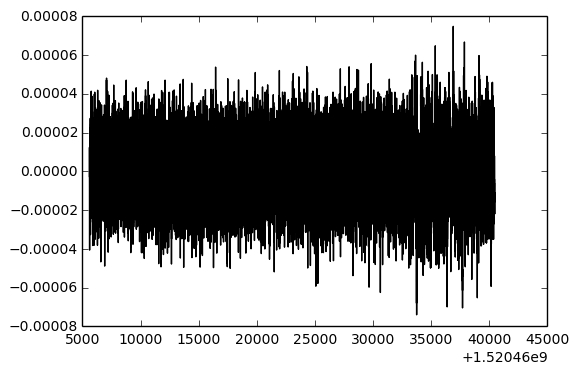

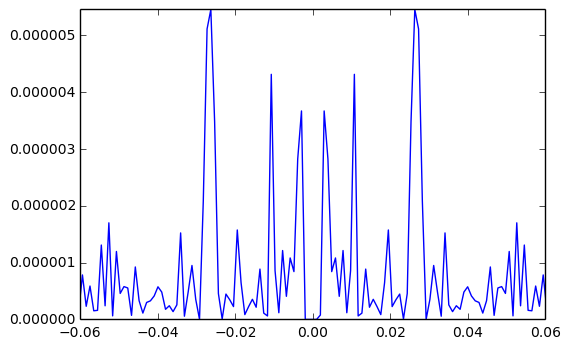

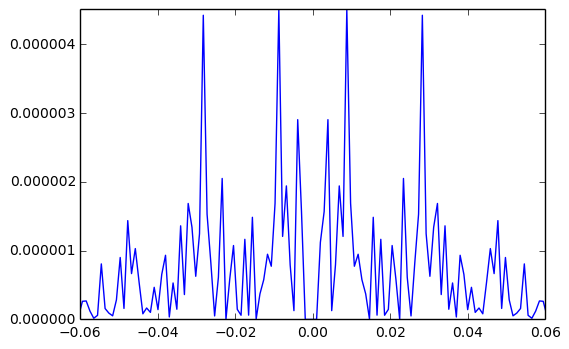

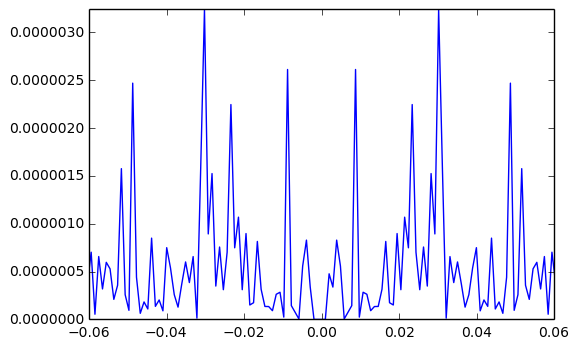

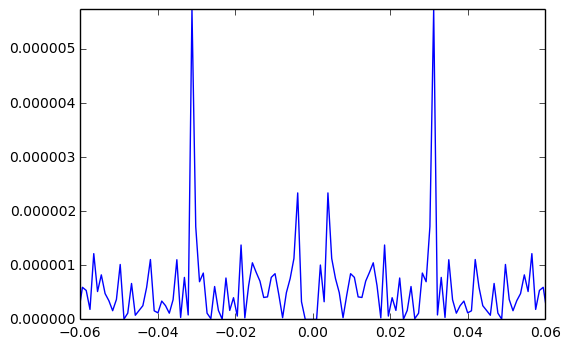

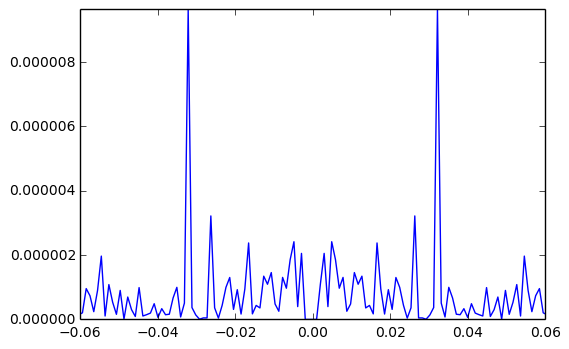

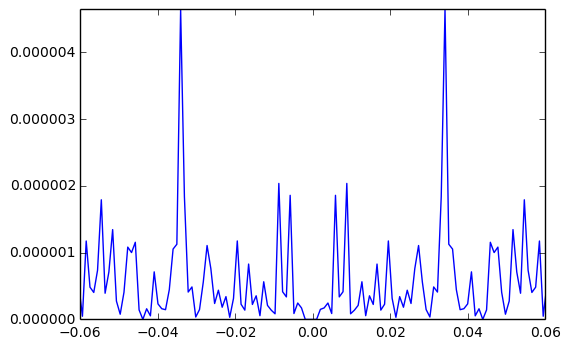

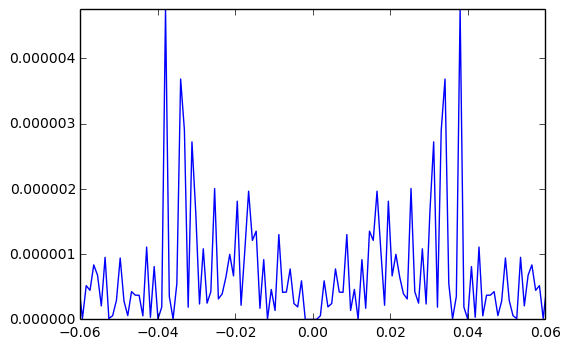

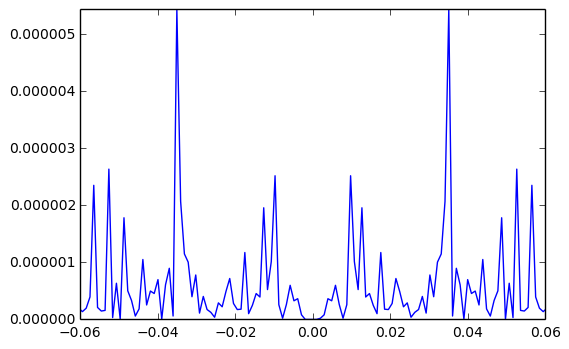

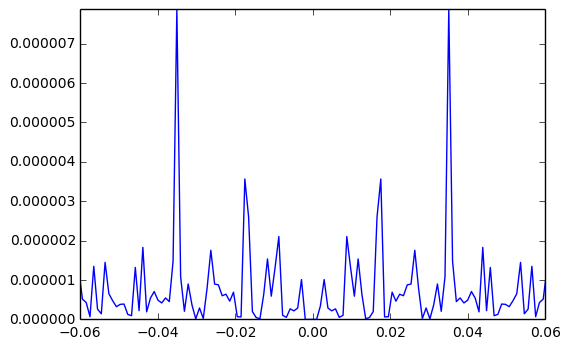

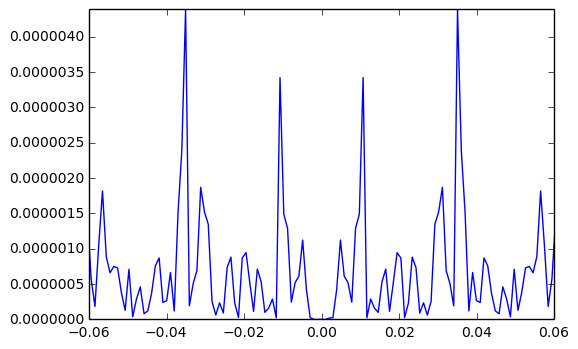

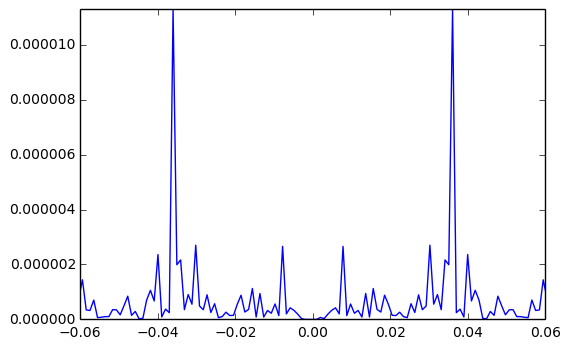

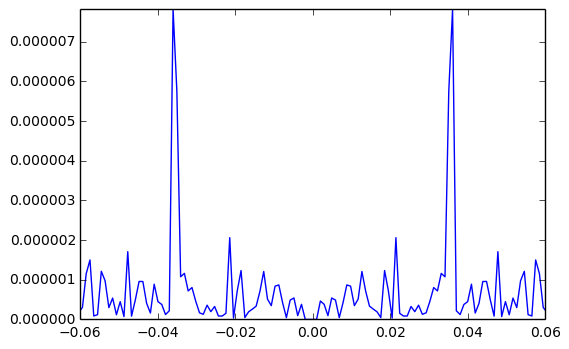

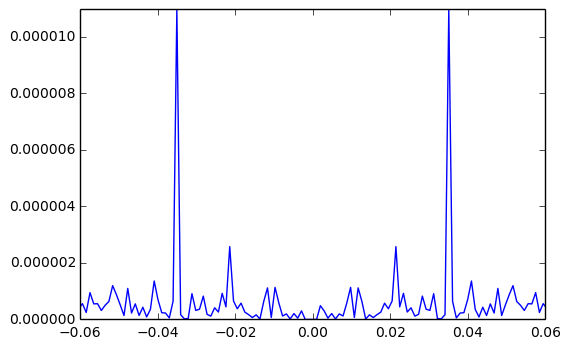

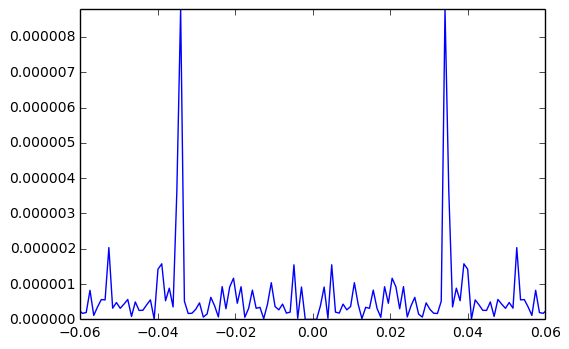

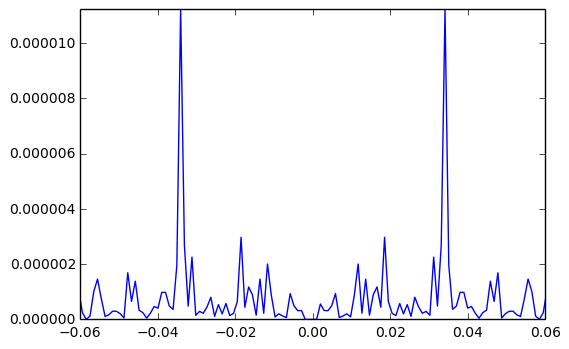

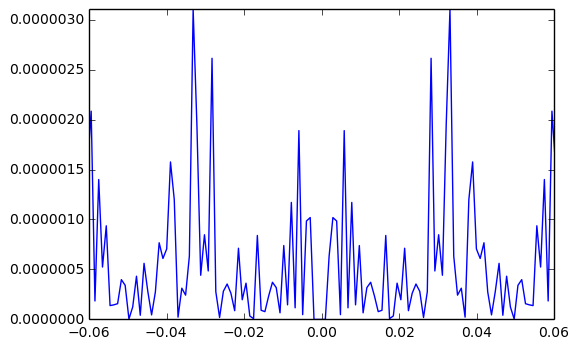

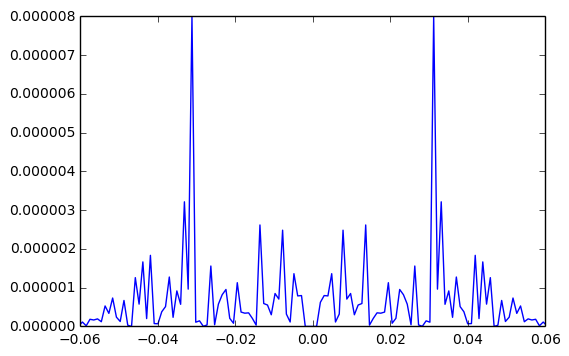

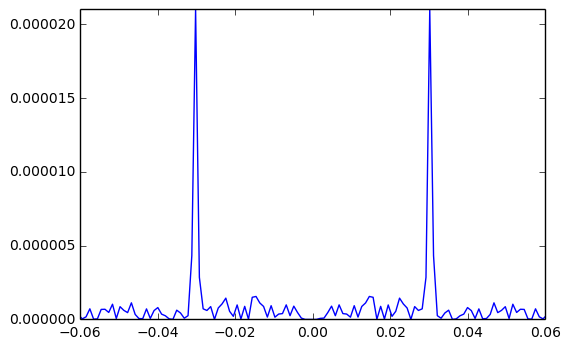

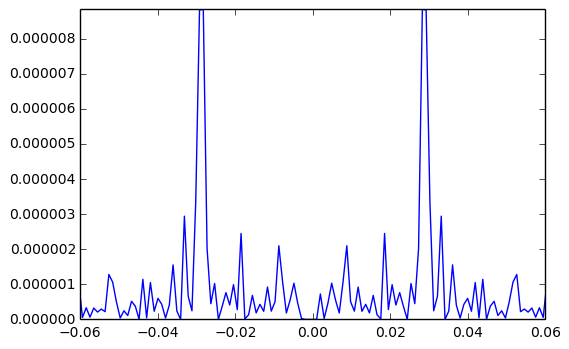

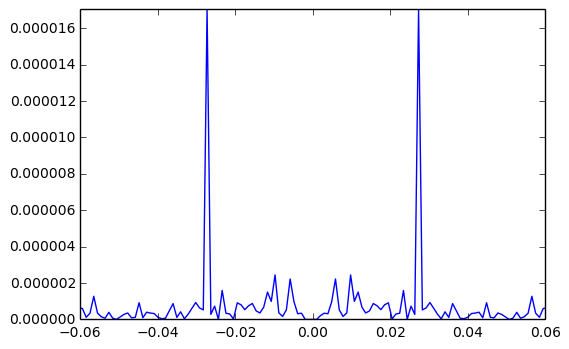

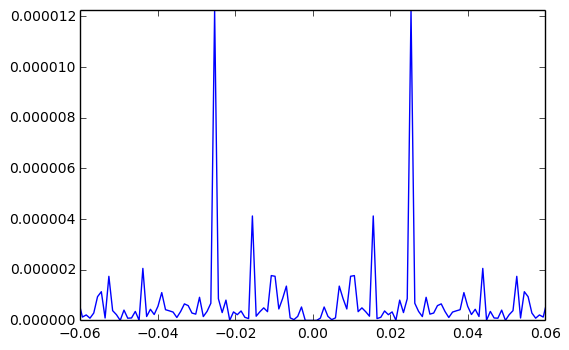

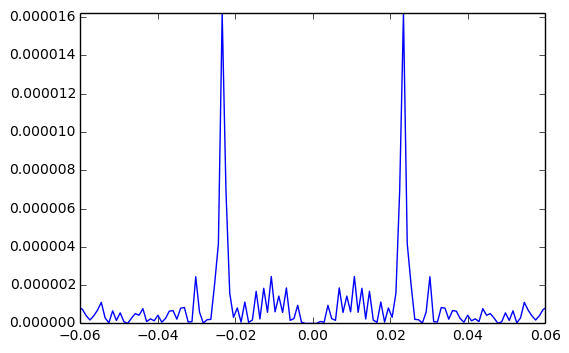

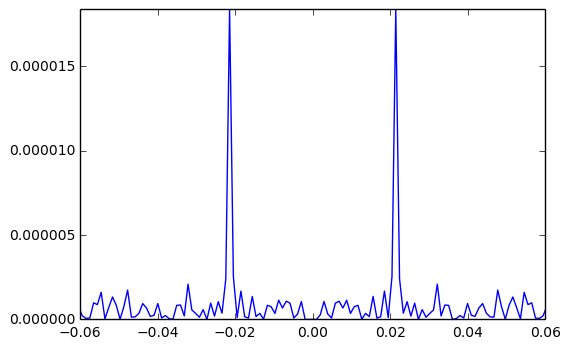

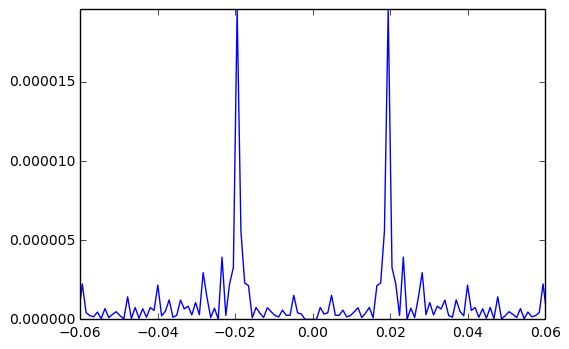

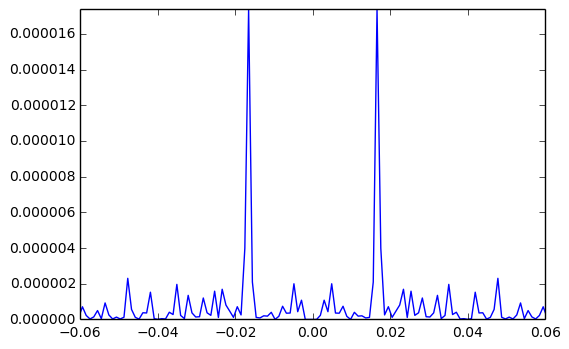

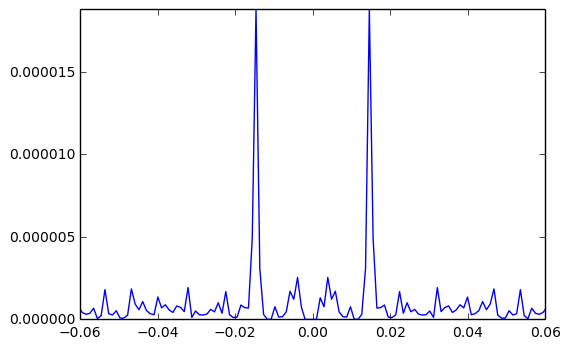

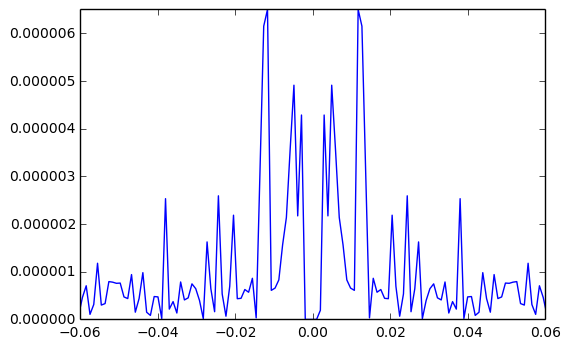

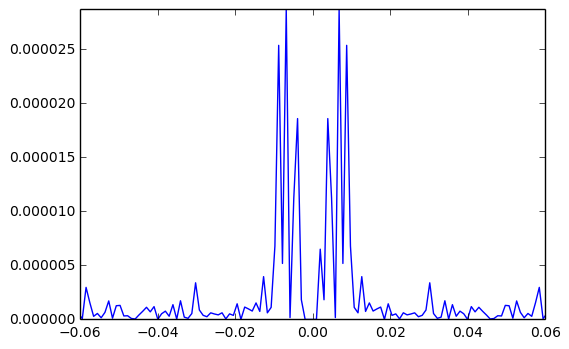

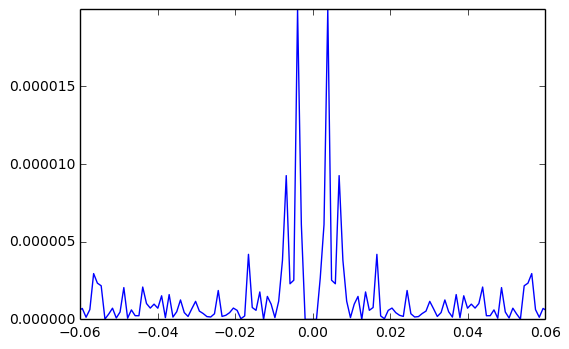

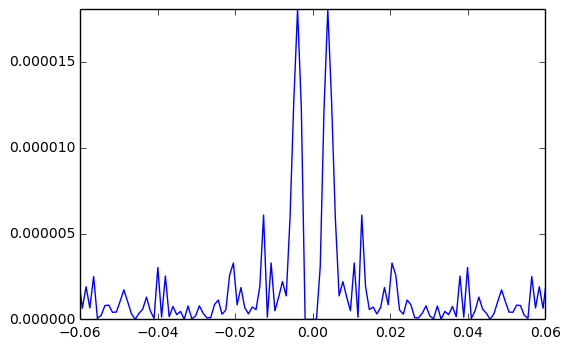

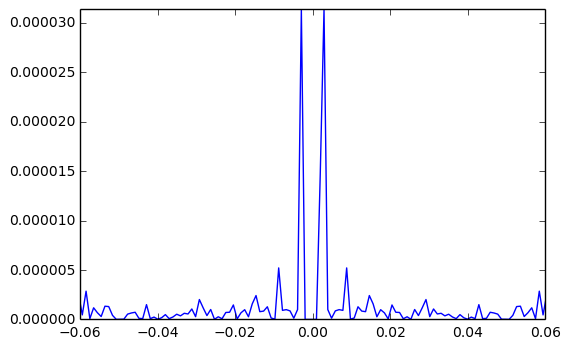

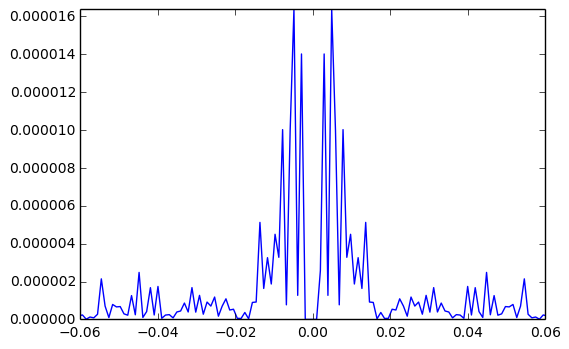

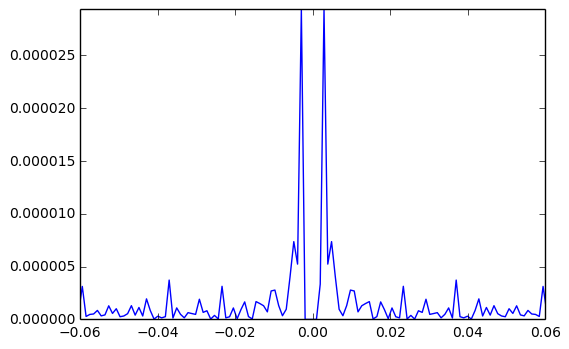

In [6]:
spacing = 186
crabV = []
print(len(crab['arr_1']))
for i in range(len(crab['arr_1'])/spacing):
    crabV[i*spacing:(i+1)*spacing] = crab["arr_1"][i*spacing:(i+1)*spacing] - np.mean(crab["arr_1"][i*spacing:(i+1)*spacing])

print(len(crabV))
pl.plot(crab['arr_0'][0:len(crabV)], crabV, 'k')
plt.figure()
spacing = 1024
for i in range(len(crabV)/spacing):
    plt.figure()
    voltage = np.fft.fft(crabV[i*spacing:(i+1)*spacing])
    freqs = np.fft.fftfreq(len(voltage), crabT)
    power = np.abs(voltage)**2
    freqsH = np.fft.fftshift(freqs)
    powerH = np.fft.fftshift(power)
    powerH[len(powerH)/2-spacing/500:len(powerH)/2+spacing/500] = 0
    plt.xlim(-0.06,.06)
    plt.ylim(0,max(powerH))
    plt.plot(freqsH, powerH)

In [6]:
dec = .38422439
spacing = 1024
lst, f_f_ideal = ideal_fringe_freq(crab, dec, spacing)
f_f_actual = actual_fringe_freq(crab, spacing)
print(f_f_actual)
print(len(f_f_actual))
print(len(lst))

[0.02631604364310812, 0.0029240048492342355, 0.001949336566156157, 0.031189385058498512, 0.001949336566156157, 0.001949336566156157, 0.038012063040045063, 0.035088058190810824, 0.035088058190810824, 0.035088058190810824, 0.036062726473888904, 0.036062726473888904, 0.035088058190810824, 0.034113389907732744, 0.034113389907732744, 0.033138721624654671, 0.031189385058498512, 0.030214716775420432, 0.028265380209264276, 0.027290711926186199, 0.02534137536003004, 0.023392038793873884, 0.021442702227717728, 0.019493365661561568, 0.016569360812327336, 0.014620024246171178, 0.001949336566156157, 0.001949336566156157, 0.001949336566156157, 0.004873341415390392, 0.001949336566156157, 0.001949336566156157, 0.0029240048492342355, 0.001949336566156157]
34
34


[0.02631604364310812, 0.0029240048492342355, 0.001949336566156157, 0.031189385058498512, 0.001949336566156157, 0.001949336566156157, 0.038012063040045063, 0.035088058190810824, 0.035088058190810824, 0.035088058190810824, 0.036062726473888904, 0.036062726473888904, 0.035088058190810824, 0.034113389907732744, 0.034113389907732744, 0.033138721624654671, 0.031189385058498512, 0.030214716775420432, 0.028265380209264276, 0.027290711926186199, 0.02534137536003004, 0.023392038793873884, 0.021442702227717728, 0.019493365661561568, 0.016569360812327336, 0.014620024246171178, 0.001949336566156157, 0.001949336566156157, 0.001949336566156157, 0.004873341415390392, 0.001949336566156157, 0.001949336566156157, 0.0029240048492342355, 0.001949336566156157]
34
34


0.0046485472986963448

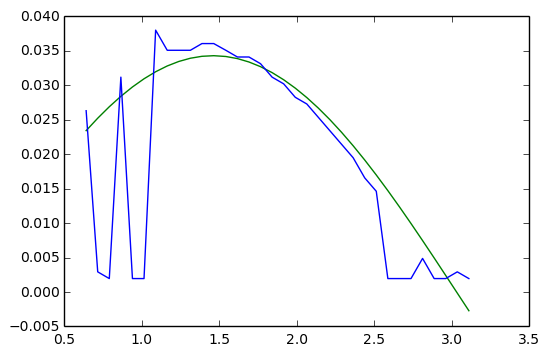

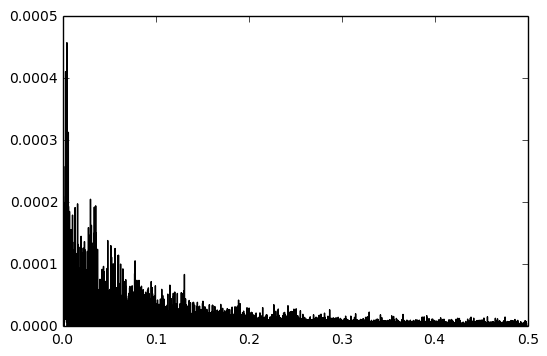

In [7]:
dec = .38422439
spacing = 1024
lst, f_f_ideal = ideal_fringe_freq(crab, dec, spacing)
f_f_actual = actual_fringe_freq(crab, spacing)
print(f_f_actual)
print(len(f_f_actual))
print(len(lst))
plt.plot(lst, f_f_ideal, 'g')
plt.plot(lst[:len(f_f_actual)], f_f_actual, 'b')
plt.figure()
plotPower(crabV, crabT, log = False)


In [8]:
print crab["arr_0"][50] - crab["arr_0"][49]

0.999449968338


## 2D Brute-Force Fitting For Baseline Determination

In [12]:
def ideal_fringe_freq(data, dec, spacing):
    f_f_ideal = []
    LST = []
    for i in range(len(data["arr_0"])/spacing):
        currentLST = ugradio.timing.lst(ugradio.timing.julian_date(data["arr_0"][i*spacing]))
        LST.append(currentLST)
        ra = 1.46
        h = currentLST - ra
        f_f_ideal.append(0.037*np.cos(dec)*np.cos(h))
    return LST, f_f_ideal


def fringes(arr, spacing, ra):
    time = arr["arr_0"]
    volts = arr["arr_1"]
    
    t_samp = (time[-1] - time[0])/len(time)
    
    f_f = []
    hours = []
    lst = []
    
    for i in range(len(time)/spacing):
        time_chunk = time[i*spacing:(i+1)*spacing] 
        
        chunk = volts[i*spacing:(i+1)*spacing] 
        chunk_avg = np.mean(chunk)
        
        # windowing
        windowed = np.multiply(chunk - chunk_avg, np.hanning(spacing))
        
        
        voltage = np.fft.fft(chunk - chunk_avg)                
        freqs = np.fft.fftfreq(len(voltage), t_samp)
        power = np.abs(voltage)**2
           
        freqsH = np.fft.fftshift(freqs)
        powerH = np.fft.fftshift(power)
          
        max_elem = np.argmax(powerH[len(power)/2:])
        f_f.append(freqsH[len(powerH)/2:][max_elem])
        
        currentLST = ugradio.timing.lst(ugradio.timing.julian_date(np.median(time_chunk)))
        hour = currentLST - ra

        hours.append(hour)
        lst.append(currentLST)
      
    return hours, f_f, lst

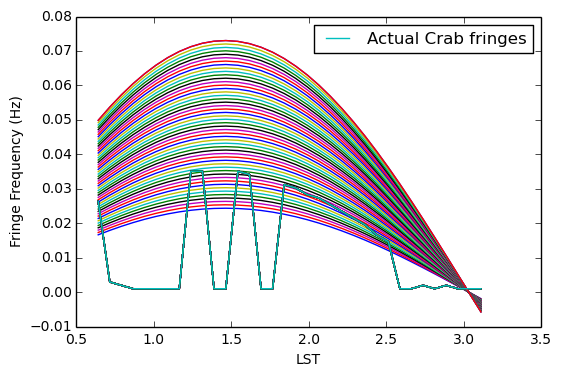

In [13]:
crab_coord = SkyCoord(l = 184.5575*u.degree, b = -5.7844*u.degree, frame = 'galactic')
crab_coord = crab_coord.fk5

s_squared = []

crab_data = np.load(data + "CrabDataR40.npz")

crab_ra, crab_dec = crab_coord.ra.rad, crab_coord.dec.rad


possible_bew = np.linspace(10, 30)

hours, actual_crab_fringes, lst = fringes(crab_data, 1024, crab_ra)

possible_qew = (possible_bew/2.77e-2) 

def ideal_fringe_freq(data, dec, spacing, qew):
    f_f_ideal = []
    LST = []
    for i in range(len(data["arr_0"])/spacing):
        currentLST = ugradio.timing.lst(ugradio.timing.julian_date(data["arr_0"][i*spacing]))
        LST.append(currentLST)
        ra = 1.46
        h = currentLST - ra
        factor = (2*np.pi)/(3600*24)
        f_f_ideal.append(factor*qew*np.cos(dec)*np.cos(h))
    return LST, f_f_ideal

for qew in possible_qew: 
    LST, calculated_crab_fringes = ideal_fringe_freq(crab_data, crab_dec, 1024, qew)
    res = np.asarray(calculated_crab_fringes) - actual_crab_fringes
    
    plt.plot(LST, calculated_crab_fringes)
    plt.plot(LST, actual_crab_fringes)
    plt.xlabel("LST")
    plt.ylabel("Fringe Frequency (Hz)")
    
    
    S = np.sum(res)
    s_squared.append(S**2)

plt.plot(LST, calculated_crab_fringes)
plt.plot(LST, actual_crab_fringes, label = "Actual Crab fringes")
       
plt.legend()


# print(np.cos(hours))
# plt.scatter(lst, actual_crab_fringes)
# plt.plot(lst, calculated_crab_fringes, 'g')

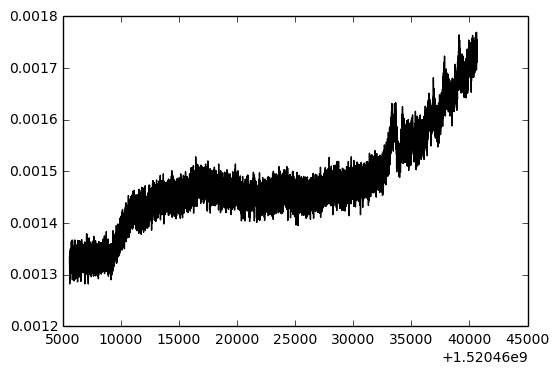

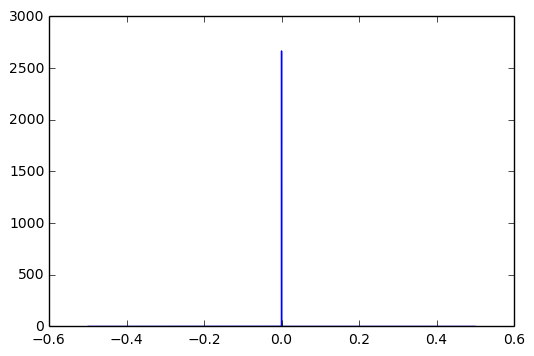

In [11]:
plt.plot(crab['arr_0'], crab["arr_1"], 'k')
plt.figure()
crabV = crab["arr_1"]
voltage = np.fft.fft(crabV)
freqs = np.fft.fftfreq(len(voltage), crabT)
power = np.abs(voltage)**2
freqsH = np.fft.fftshift(freqs)
powerH = np.fft.fftshift(power)
plt.plot(freqsH, powerH)

In [12]:
spacing = 10
crabV = []
for i in range(len(crab['arr_1'])/spacing):
    crabV[i*spacing:(i+1)*spacing] = crab["arr_1"][i*spacing:(i+1)*spacing] - np.mean(crab["arr_1"][i*spacing:(i+1)*spacing])

print(len(crabV))

34960


In [13]:
spacing = 173
sunV = []
for i in range(len(sun['arr_1'])/spacing):
    sunV[i*spacing:(i+1)*spacing] = sun["arr_1"][i*spacing:(i+1)*spacing] - np.mean(sun["arr_1"][i*spacing:(i+1)*spacing])

print(len(sunV))

29929


29929
[[  4.35188436e-14   8.09237600e-13   2.96761138e-13 ...,   5.41749413e-13
    2.96761138e-13   8.09237600e-13]
 [  6.17874759e-14   4.95599323e-12   1.85744036e-13 ...,   1.50588127e-12
    1.85744036e-13   4.95599323e-12]
 [  1.83151875e-12   2.30820730e-12   1.07803810e-12 ...,   3.12229843e-12
    1.07803810e-12   2.30820730e-12]
 ..., 
 [  4.73120107e-12   4.86536011e-09   7.53950376e-10 ...,   1.45534862e-09
    7.53950376e-10   4.86536011e-09]
 [  3.18651018e-09   3.68515042e-09   1.72436607e-10 ...,   2.13709131e-09
    1.72436607e-10   3.68515042e-09]
 [  1.28929420e-09   1.02462772e-09   1.24931895e-09 ...,   3.77579238e-11
    1.24931895e-09   1.02462772e-09]]


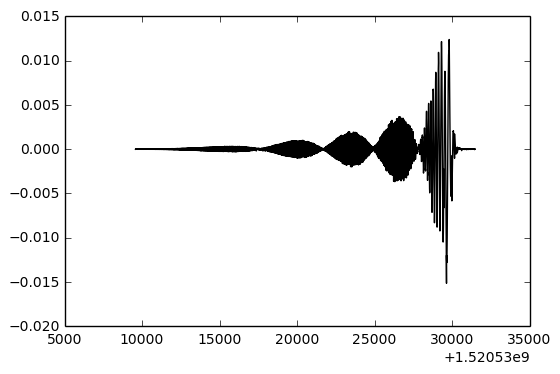

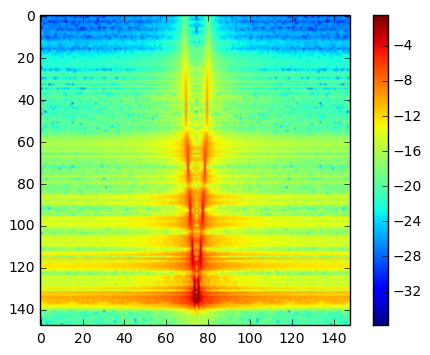

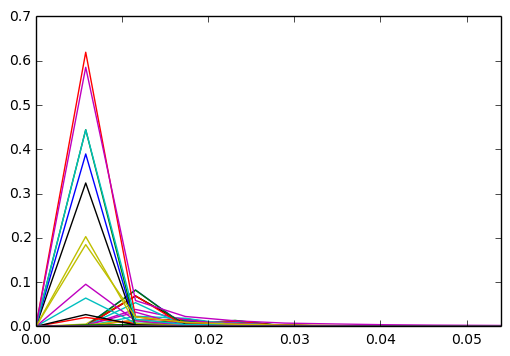

In [30]:
pl.plot(sun['arr_0'][0:21904], sunV[:21904], 'k')
print(len(sunV))
plt.figure()
#sunV = np.multiply(sunV, np.hamming(len(sunV)))
sun_reshape = np.array(sunV[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
print(np.abs(sun_fft_two_d)**2)
plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()
spacing = 173
for i in range(len(sunV)/spacing):
    #plt.figure()
    voltage = np.fft.fft(sunV[i*spacing:(i+1)*spacing])
    freqs = np.fft.fftfreq(len(voltage), sunT)
    power = np.abs(voltage)**2
    freqsH = np.fft.fftshift(freqs)
    powerH = np.fft.fftshift(power)
    powerH[len(powerH)/2-spacing/500:len(powerH)/2+spacing/500] = 0
    plt.xlim(0,.054)
    #plt.ylim(0,max(powerH))
    plt.plot(freqsH, powerH)

29956
23998
[[  2.50000000e-09   2.92404606e-08   4.69339751e-10 ...,   7.90612193e-09
    4.69339751e-10   2.92404606e-08]
 [  2.30400000e-09   1.35004861e-08   3.59613659e-10 ...,   2.40724474e-09
    3.59613659e-10   1.35004861e-08]
 [  2.75560000e-08   3.62851378e-09   4.12709476e-09 ...,   3.71407960e-09
    4.12709476e-09   3.62851378e-09]
 ..., 
 [  3.02500000e-09   1.88867410e-08   2.08411749e-09 ...,   7.19829494e-09
    2.08411749e-09   1.88867410e-08]
 [  5.04100000e-09   1.63713419e-08   1.18206345e-08 ...,   2.96338168e-08
    1.18206345e-08   1.63713419e-08]
 [  9.21600000e-09   5.87528767e-10   8.44842287e-09 ...,   9.20953492e-09
    8.44842287e-09   5.87528767e-10]]


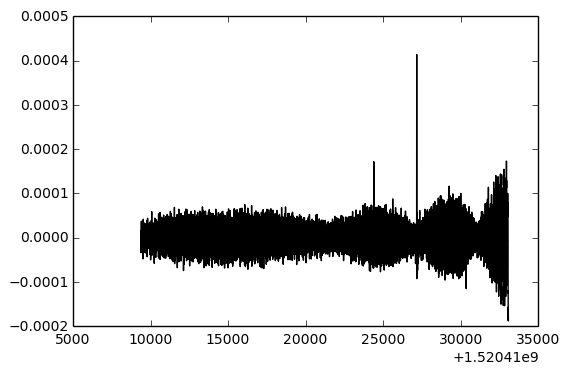

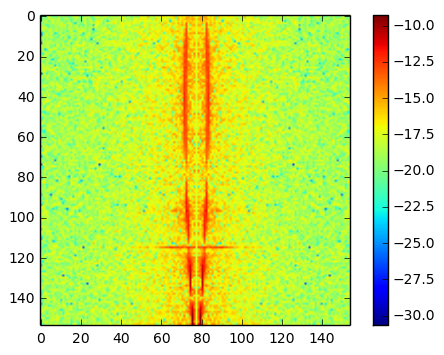

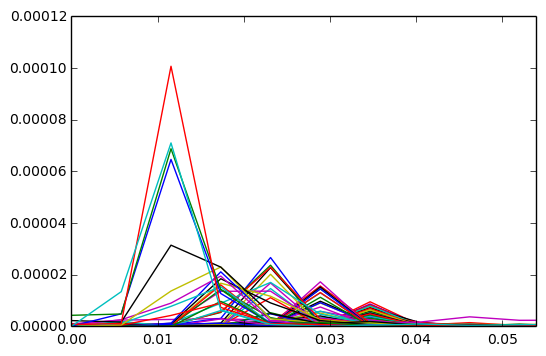

In [48]:
spacing = 154
moonV = []
for i in range(len(moon['arr_1'])/spacing):
    moonV[i*spacing:(i+1)*spacing] = moon["arr_1"][i*spacing:(i+1)*spacing] - np.mean(moon["arr_1"][i*spacing:(i+1)*spacing]) + .000001

print(len(sunV))
pl.plot(moon['arr_0'][0:23716], moonV[:23716], 'k')
print(len(moon['arr_0']))
plt.figure()
moon_reshape = np.array(moonV[:23716]).reshape((154,154))
moon_fft_two_d = np.fft.fftshift(np.fft.fft(moon_reshape), axes = 1)
print(np.abs(moon_fft_two_d)**2)

for i in range(len(moon_fft_two_d[:])):
    moon_fft_two_d[i][0] = np.median(moon_fft_two_d[i][:])
    
plt.imshow((np.log(np.abs(moon_fft_two_d)**2)), )
plt.colorbar()
plt.figure()
spacing = 173
for i in range(len(moonV)/spacing):
    #plt.figure()
    voltage = np.fft.fft(moonV[i*spacing:(i+1)*spacing])
    freqs = np.fft.fftfreq(len(voltage), sunT)
    power = np.abs(voltage)**2
    freqsH = np.fft.fftshift(freqs)
    powerH = np.fft.fftshift(power)
    powerH[len(powerH)/2-spacing/500:len(powerH)/2+spacing/500] = 0
    plt.xlim(0,.054)
    #plt.ylim(0,max(powerH))
    plt.plot(freqsH, powerH)

34967
[[  1.08900000e-09   1.97841288e-08   7.27278418e-09 ...,   1.32962221e-08
    7.27278418e-09   1.97841288e-08]
 [  1.56367673e-09   1.17450213e-07   4.34880782e-09 ...,   3.53781428e-08
    4.34880782e-09   1.17450213e-07]
 [  4.24360000e-08   5.27769283e-08   2.48538710e-08 ...,   7.18926725e-08
    2.48538710e-08   5.27769283e-08]
 ..., 
 [  8.10000000e-11   3.09718177e-08   4.68125755e-09 ...,   9.10386903e-09
    4.68125755e-09   3.09718177e-08]
 [  2.26076429e-08   2.60474873e-08   1.16331282e-09 ...,   1.49072398e-08
    1.16331282e-09   2.60474873e-08]
 [  1.02010000e-08   8.13490139e-09   9.86211200e-09 ...,   2.95870563e-10
    9.86211200e-09   8.13490139e-09]]


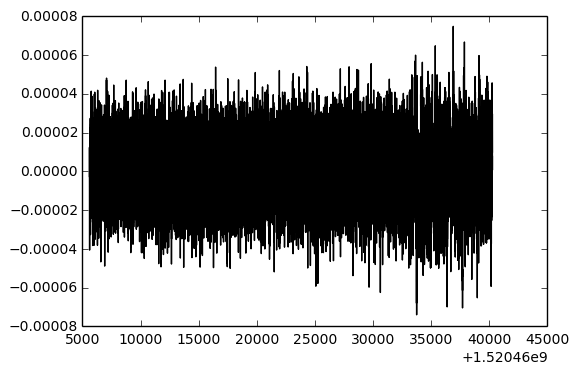

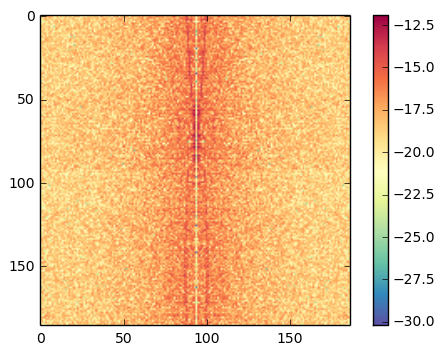

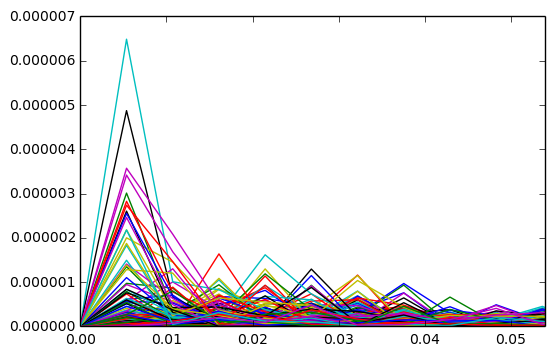

In [16]:
spacing = 186
crabV = []
for i in range(len(crab['arr_1'])/spacing):
    crabV[i*spacing:(i+1)*spacing] = crab["arr_1"][i*spacing:(i+1)*spacing] - np.mean(crab["arr_1"][i*spacing:(i+1)*spacing])
    #crabV[i*spacing:(i+1)*spacing] = crab["arr_1"][i*spacing:(i+1)*spacing]
pl.plot(crab['arr_0'][0:186*186], crabV[:186*186], 'k')
print(len(crab['arr_0']))

plt.figure()
crab_reshape = np.array(crabV[:186*186]).reshape((186,186))
crab_fft_two_d = np.fft.fft(crab_reshape)


for i in range(len(crab_fft_two_d[:])):
    crab_fft_two_d[i][0] = np.median(crab_fft_two_d[i][:])
print(np.abs(sun_fft_two_d)**2)


plt.imshow(np.fft.fftshift(np.log(np.abs(crab_fft_two_d)**2 )), axes = 1, cmap="Spectral_r")
plt.colorbar()
plt.figure()
spacing = 186
for i in range(len(crab['arr_0'])/spacing):
    #plt.figure()
    voltage = np.fft.fft(crabV[i*spacing:(i+1)*spacing])
    freqs = np.fft.fftfreq(len(voltage), crabT)
    power = np.abs(voltage)**2
    freqsH = np.fft.fftshift(freqs)
    powerH = np.fft.fftshift(power)
    #powerH[len(powerH)/2-spacing/500:len(powerH)/2+spacing/500] = 0
    plt.xlim(0,.054)
    #plt.ylim(0,max(powerH))
    plt.plot(freqsH, powerH)

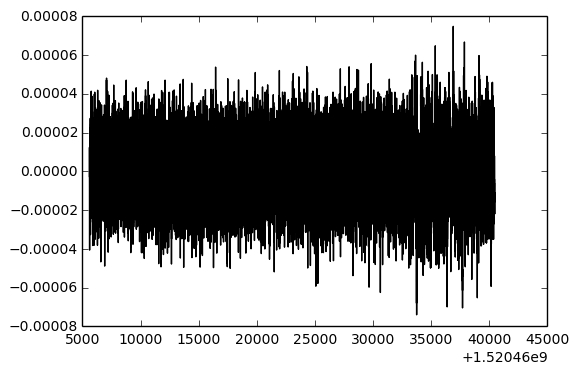

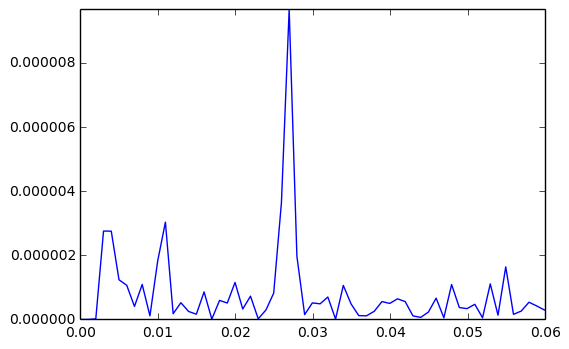

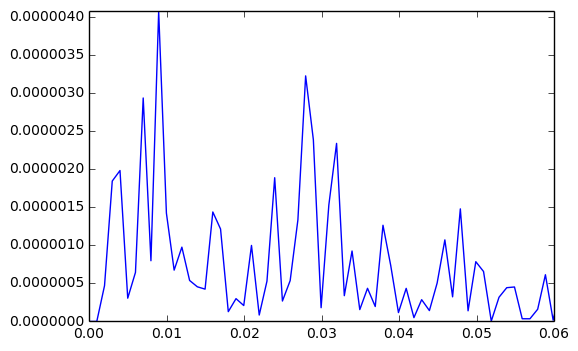

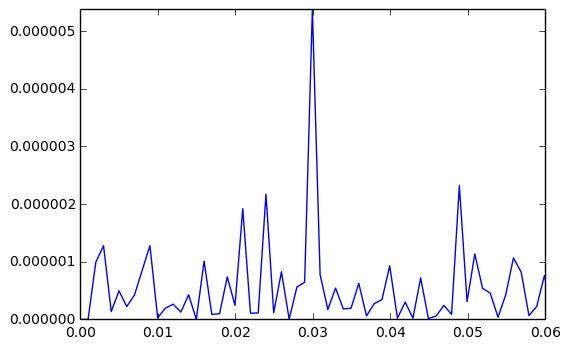

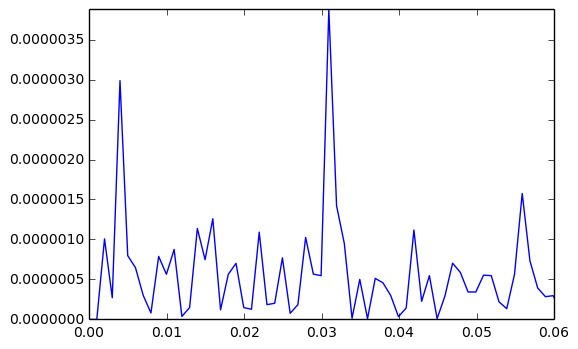

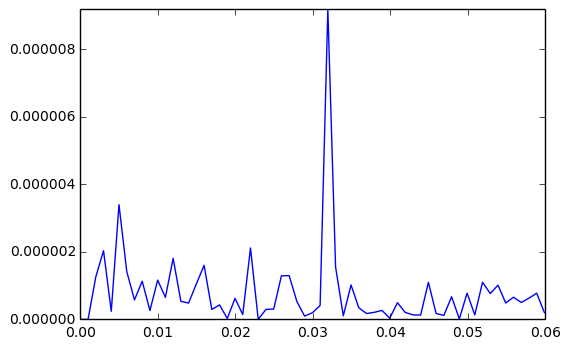

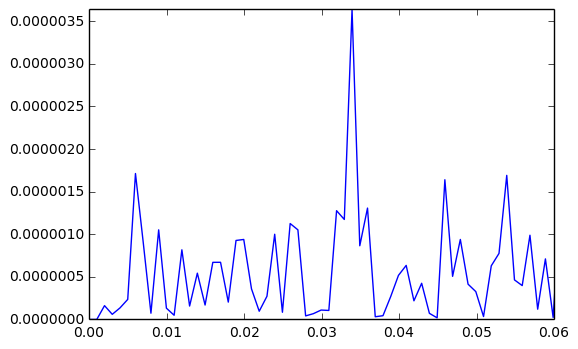

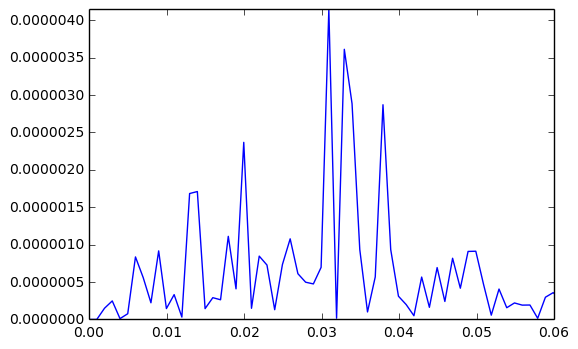

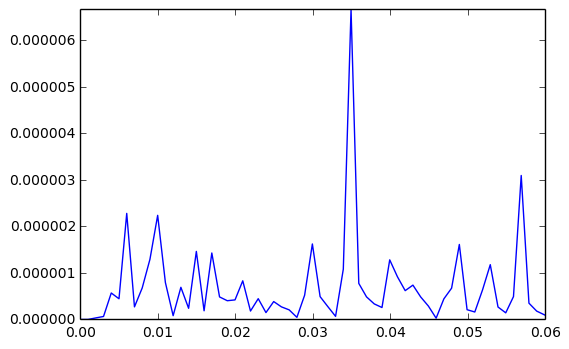

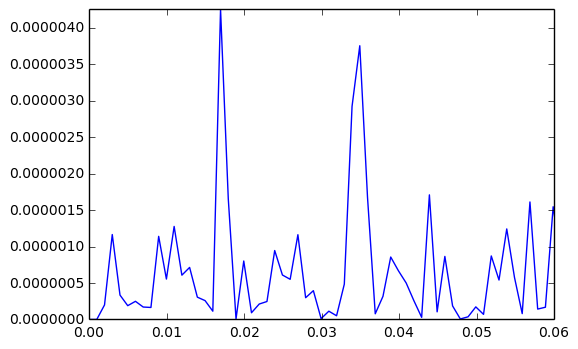

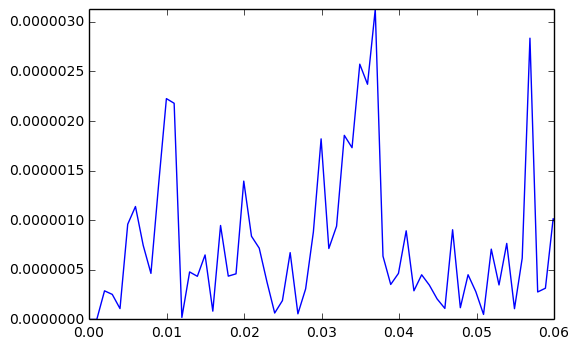

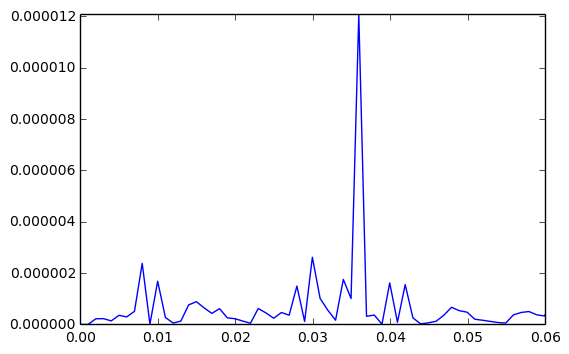

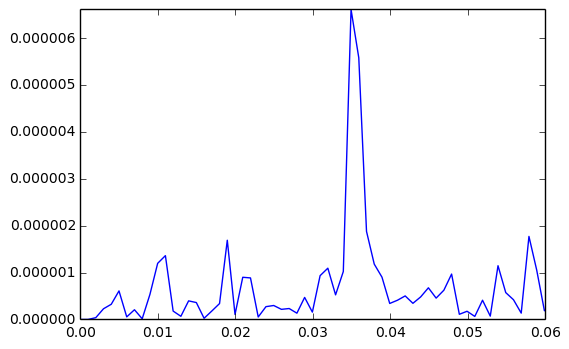

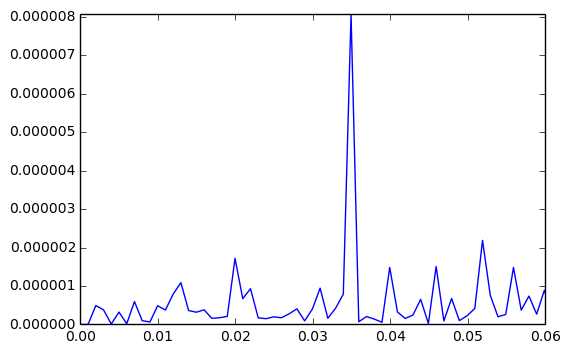

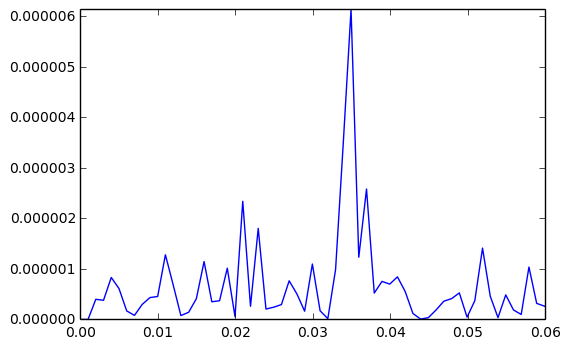

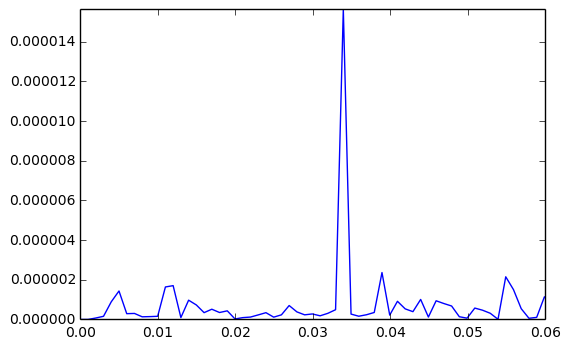

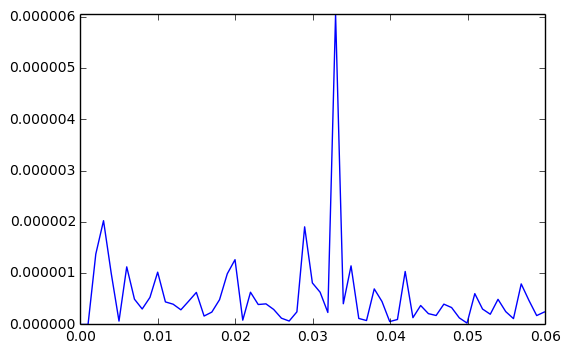

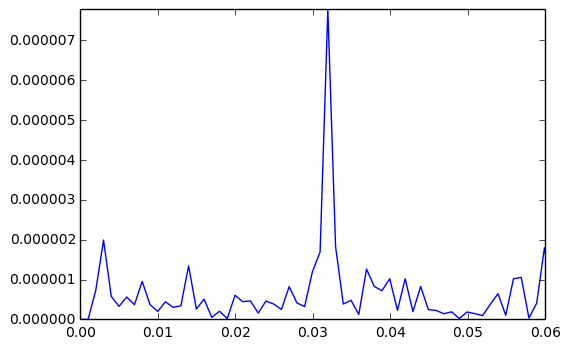

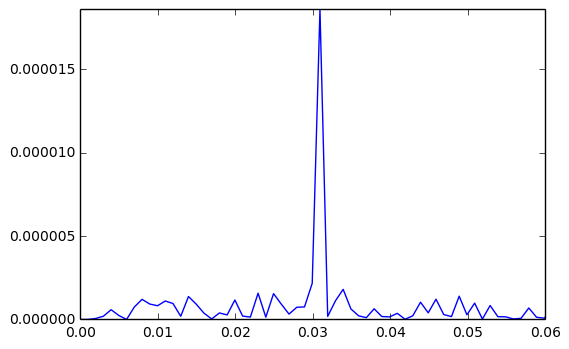

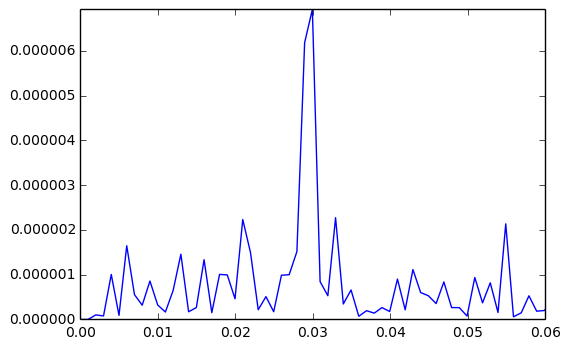

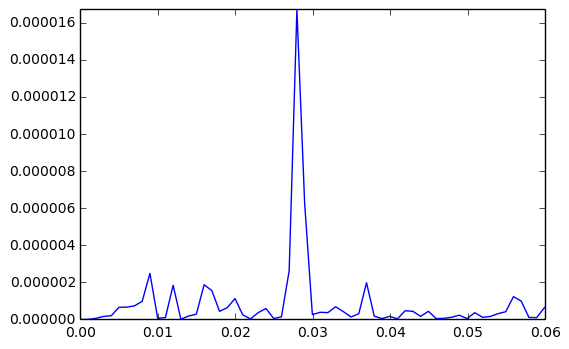

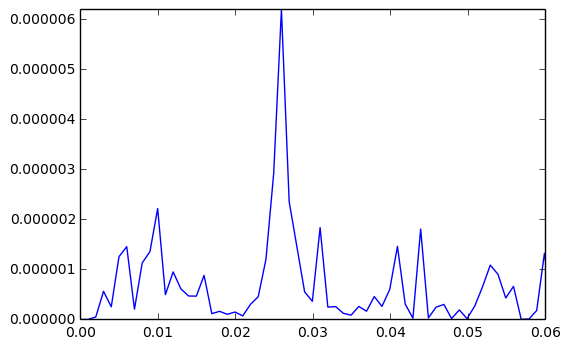

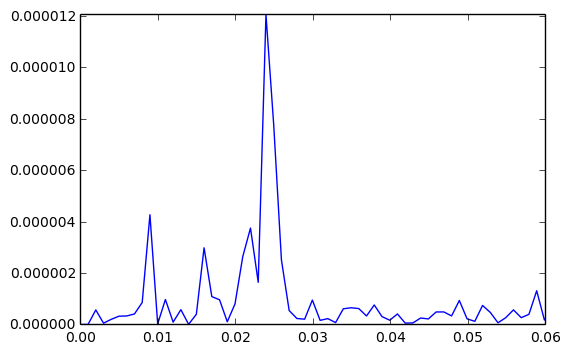

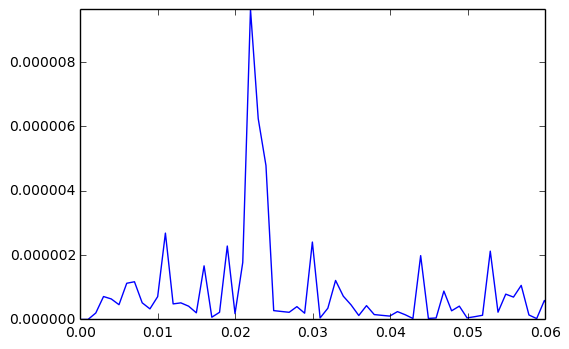

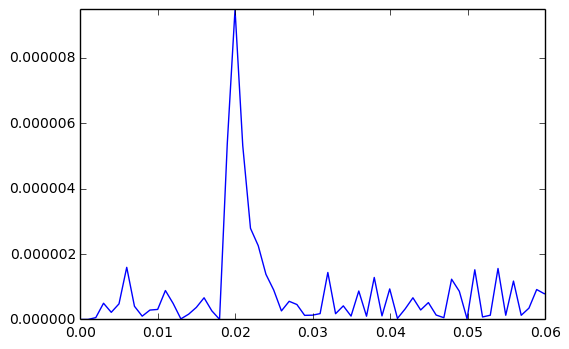

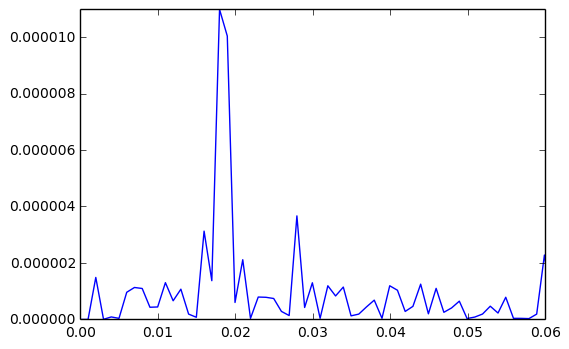

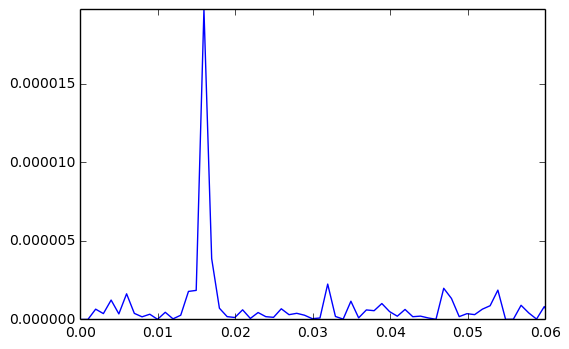

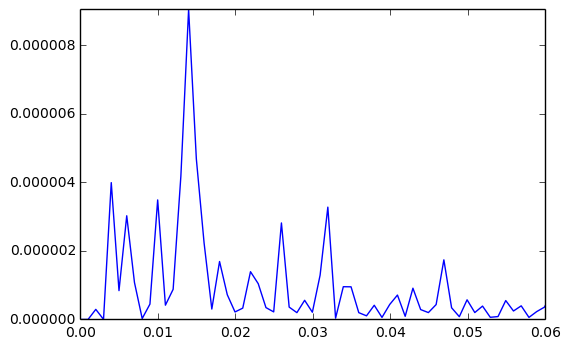

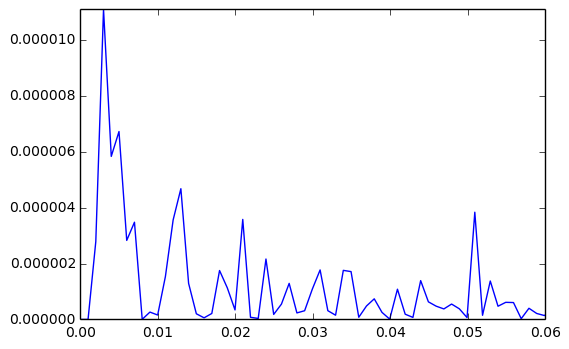

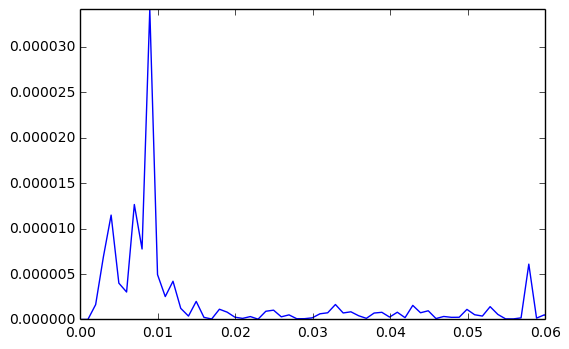

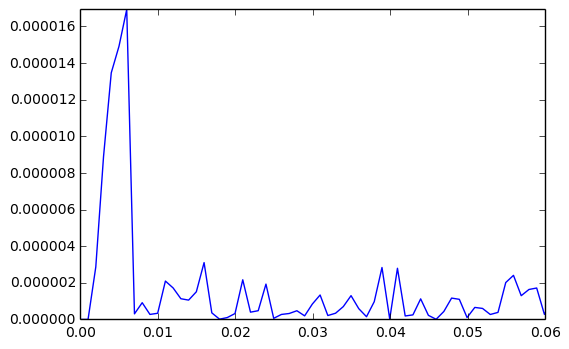

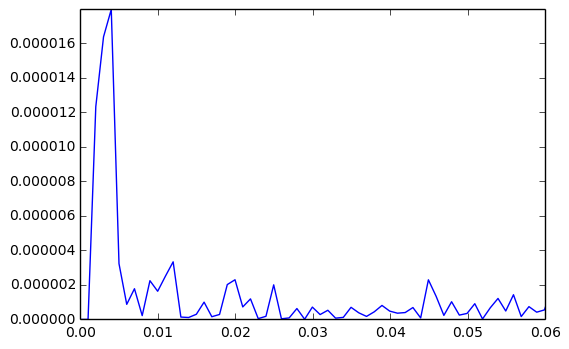

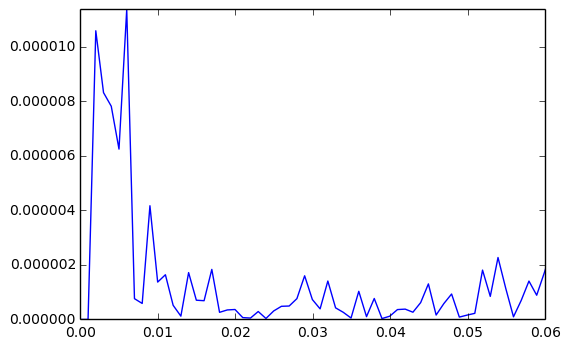

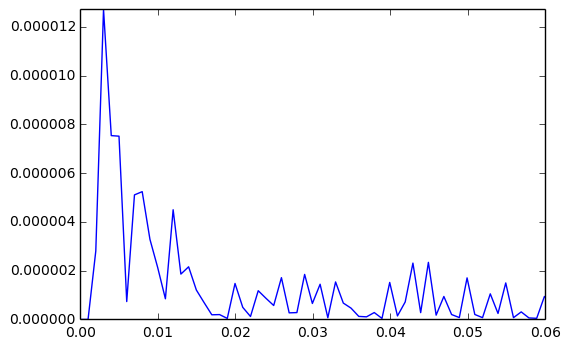

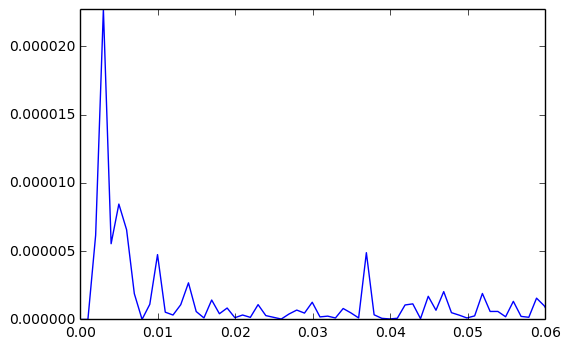

In [17]:
pl.plot(crab['arr_0'][0:len(crabV)], crabV, 'k')
plt.figure()
spacing = 1000
for i in range(len(crabV)/spacing):
    plt.figure()
    voltage = np.fft.fft(crabV[i*spacing:(i+1)*spacing])
    freqs = np.fft.fftfreq(len(voltage), crabT)
    power = np.abs(voltage)**2
    freqsH = np.fft.fftshift(freqs)
    powerH = np.fft.fftshift(power)
    powerH[len(powerH)/2-spacing/500:len(powerH)/2+spacing/500] = 0
    plt.xlim(0,.06)
    plt.ylim(0,max(powerH))
    plt.plot(freqsH, powerH)

29929


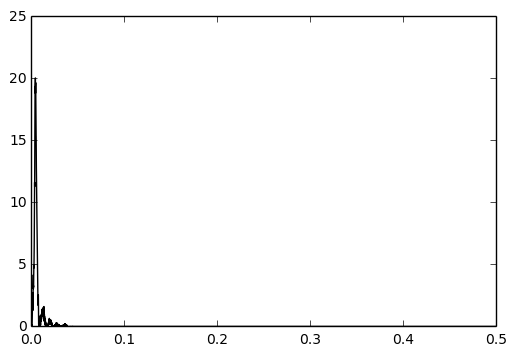

In [18]:

plotPower(sunV, sunT)
print len(sunV)

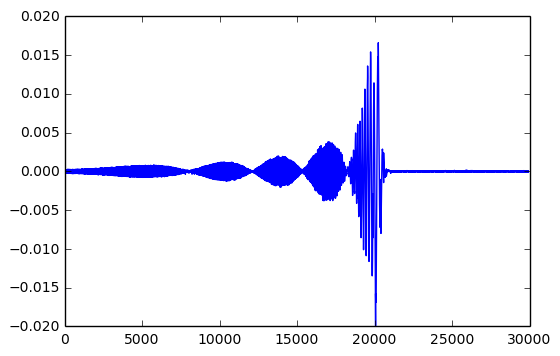

In [19]:
pl.plot(sunV)





-0.496338763289
0.0311893850585
0.0122293998297


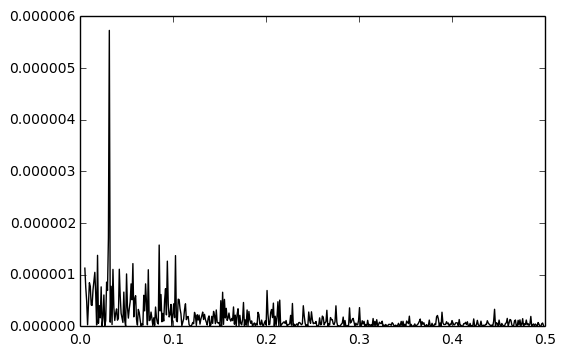

In [20]:
i=3
f_f_actual = plotPower(crabV[1024*i:1024*(i+1)], crabT)
beginLST = 0.963661236711
ra = 1.46
h = beginLST - ra
print h
f_f_ideal = 0.015*np.cos(.384)*np.cos(h)
print f_f_actual
print f_f_ideal

In [21]:
# Attempting the Brute Force Method using ff = f_f_actual = 0.0351563613636
ff = 0.0351563613636
ha = 2*np.pi*-0.496338763289
Qew_guess = ff/np.cos(ha)
nu_tau = 2*np.pi*Qew_guess*np.sin(ha)
crab

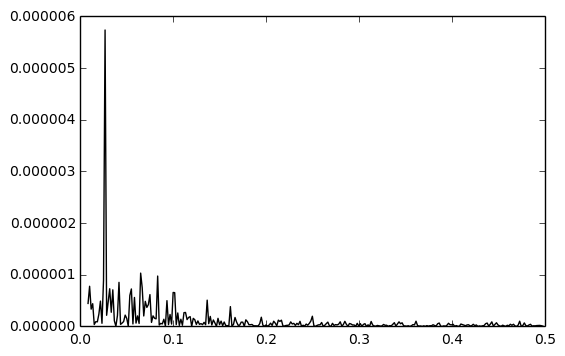

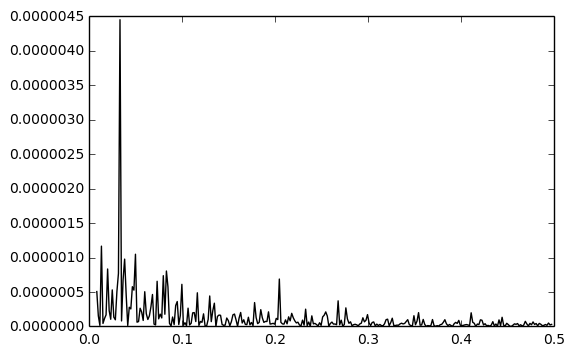

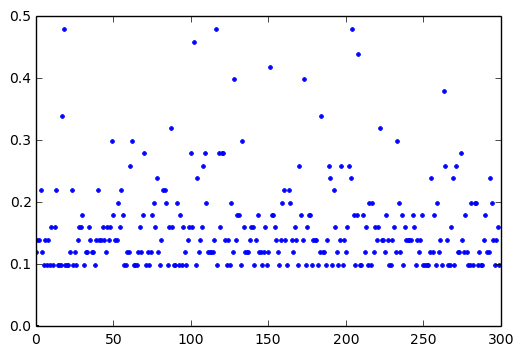

In [22]:
#print(len(crabV))
plotPower(crabV[:600], crabT)
pl.figure()
plotPower(crabV[6000:6600], crabT)
pl.figure()
plotPower(crabV[-512:], crabT)
freqs1 = []
for i in range(15000/50):
    freqs1.append(plotPower(crabV[i*50:(i+1)*50], crabT))
#print(len(freqs1))
#print(freqs1)
pl.plot(freqs1, '.')



$\huge{f_{fringe} \approx (\frac{B_{ew}}{\lambda} \cos \delta) \cos{h_{s,o}}}$

print "f_f is " + str((20/.025)*np.cos((2*np.pi/360)*22.0144)*np.cos(0.9636616196717481


-((np.pi/180)*83.6))-(20/.025)*np.cos((2*np.pi/360)*22.0144)*np.cos(2.058860770834483

-((np.pi/180)*83.6)))



In [23]:
1/.015*np.cos(np.radians(22.0144))*np.cos(8)

-8.9927719504510168

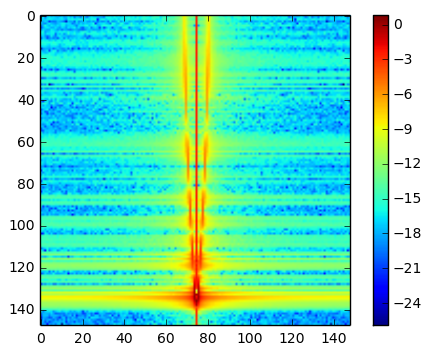

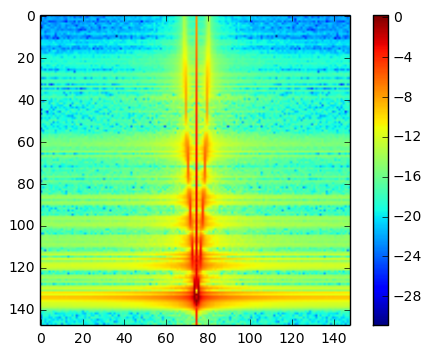

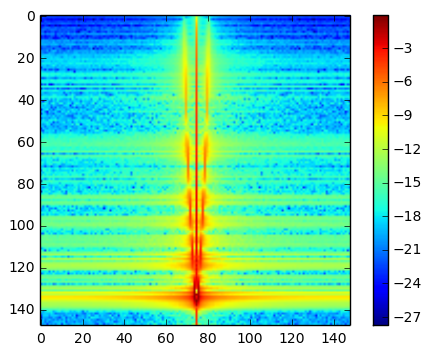

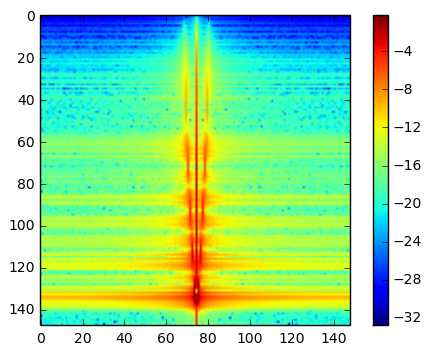

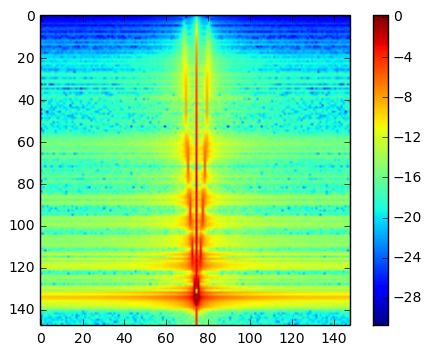

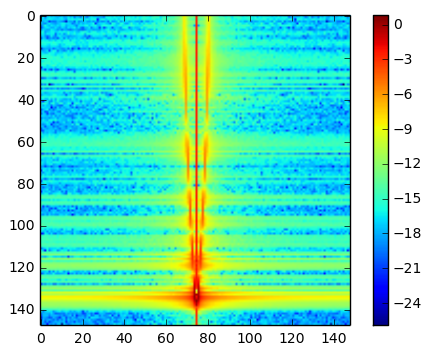

In [36]:
#sunV = np.multiply(sunV, np.hamming(len(sunV)))
sun_reshape = np.array(sunV[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()
sunV2 = np.multiply(sunV, np.hamming(len(sunV)))
sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()
sunV2 = np.multiply(sunV, np.bartlett(len(sunV)))
sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()
sunV2 = np.multiply(sunV, np.blackman(len(sunV)))
sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()
sunV2 = np.multiply(sunV, np.hanning(len(sunV)))
sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()
sunV2 = np.multiply(sunV, np.kaiser(1,len(sunV)))
sun_reshape = np.array(sunV2[:21904]).reshape((148,148))
sun_fft_two_d = np.fft.fftshift(np.fft.fft(sun_reshape), axes = 1)
plt.imshow((np.log(np.abs(sun_fft_two_d)**2)))
plt.colorbar()
plt.figure()

TypeError: Image data can not convert to float

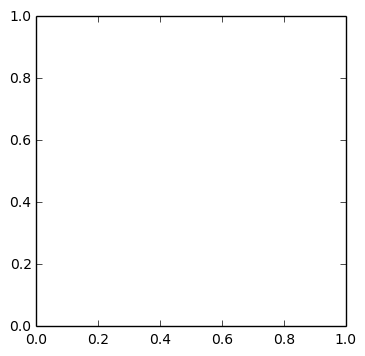

In [59]:

sunFT = np.fft.fftshift(

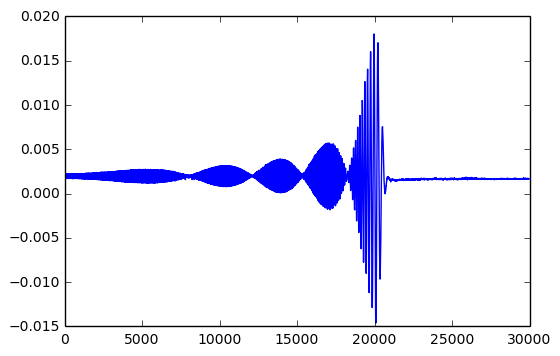

In [14]:
pl.plot(sunV)

In [ ]:
x = np.linspace(0, 21000, num=21000)
y = sunV[:21000]
p = np.polyfit(x, y, 5)
pl.plot(x, np.polyval(p, x), "r")